In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import names
import sys
import collections
import threading

sns.set(style="white")


In [2]:
dis_threshold = 20           # effective radius
base_prob = 0.5             # probability of successful transmission set in nearest distance
Lecture_time = 45            # in minutes
Listening_time = 29 * 1000  # time for listening
Sending_time = 1 * 1000    # time for advertising
Number_of_students = 10
Testing_times = 10           # loop times to get average performance
Classroom_height = 4        # size parameter
Classroom_width = 5       # size parameter
base_name = 1
time = 0
fail_count = 0
attend_duration_arr = []

In [3]:
class State:
    def __init__(self):
        self.LISTENING = "LISTENING"
        self.SENDING = "SENDING"

state = State()

In [4]:
class Teacher:
    def __init__(self, x = None, y = None):
        self.x = x
        self.y = y
        self.identity = 'Teacher'
        self.label = 0
        self.teacher_listening_time = 59 * 1000
        self.teacher_sending_time = 1 * 1000
        self.cur_state = state.SENDING
        self.relay = []
        self.prob_dict = {}
        
    def update_state(self):
        # it has label
        module = time % (self.teacher_listening_time + self.teacher_sending_time)
        if module <= self.teacher_listening_time:
            self.cur_state = state.LISTENING
        else:
            self.cur_state = state.SENDING
            
    def listen(self, students):
        if self.cur_state == state.LISTENING:
            for s in students:
                if ((s.label == 1) and (s.cur_state == state.SENDING)):
                    if self not in s.prob_dict.keys():
                        p = pathloss_prob(cal_dis(self.x,self.y,s.x,s.y))
                        s.prob_dict[self] = p
                        self.prob_dict[s] = p
                    if (np.random.rand() < gaussian(s.prob_dict[self])):
                        self.append_relay(s.output_name())
        else:
            return
    
    def append_relay(self, name):
        l = self.relay
        l.append(name)
        self.relay = list(set(l))
        

In [5]:
class Seat:
    def __init__(self, x = None, y = None, proba = 0, anc = None, ident = 'Empty', l = None):
        self.x = x
        self.y = y
        global base_name
        self.probability = proba
        self.identity = ident # identity: Empty, Teacher, Student
        self.label = l
        self.cur_state = state.LISTENING # LISTENING, SENDING
        self.start_time_bias = np.random.randint(1000)
        self.start_time = None
        self.relay = [names.get_full_name()]
        self.output_index = 0
        self.prob_dict = {}
        
    # how the pointer shifts?
    def output_name(self):
        self.output_index += 1
        return self.relay[self.output_index % len(self.relay)]
    
    def set_x(self, x):
        self.x = x

    def set_y(self, y):
        self.y = y
        
    def set_identity(self, ident):
        self.identity = ident
        
    def set_label(self, l):
        if self.label is None:
            self.start_time = time
        if (l != self.label):
            self.label = l

    def listen(self, students, teacher, t_x, t_y):
        if self.cur_state == state.LISTENING:
            # if this student could hear from teacher
            current_dis = cal_dis(self.x, self.y, t_x, t_y)
            if (current_dis < dis_threshold):
                if teacher not in self.prob_dict.keys():
                    p = pathloss_prob(cal_dis(self.x,self.y,t_x, t_y))
                    self.prob_dict[teacher] = p
                    teacher.prob_dict[self] = p
                if (np.random.rand() < gaussian(self.prob_dict[teacher])):
                    self.set_label(1)

            for s in students:
                # if this student is listening AND that student is sending AND they are close enough
                current_dis = cal_dis(self.x, self.y, s.x, s.y)
                if ((s.cur_state == state.SENDING) & (current_dis < dis_threshold)):
                    if self not in s.prob_dict.keys():
                        p = pathloss_prob(cal_dis(self.x,self.y,s.x,s.y))
                        s.prob_dict[self] = p
                        self.prob_dict[s] = p
                    if (np.random.rand() < gaussian(s.prob_dict[self])):
                        # This student may not be working now
                        # if this student hasn't been labeled yet,
                        # OR this student's label is 2+ level higher than than sender
                        # which means it need to update the label!!
                        if (self.label is None) or (s.label < self.label - 1):
                            # update this student's label to just 1 level higher than sender
                            self.set_label(s.label + 1)
                        # if this student's label is 1 level lower than sender, help relay
                        elif (s.label == self.label + 1):
                            self.append_relay(s.output_name())
        else:
            return
                          
    def append_relay(self, name):
        l = self.relay
        l.append(name)
        self.relay = list(set(l))
        
    def update_state(self):
        # if this student has no label, he/she should be listening
        if (self.label is None):
            self.cur_state = state.LISTENING
        else:
            # it has label
            # if current time hasn't hit (time student hear lecturer + time bias)
            # keep this student in listening mode
            if time < (self.start_time + self.start_time_bias):
                self.cur_state = state.LISTENING
            # when first time advertising
            else:
                module = (time - self.start_time_bias - self.start_time) % (Listening_time + Sending_time)
                if module < Sending_time:
                    self.cur_state = state.SENDING
                else:
                    self.cur_state = state.LISTENING
                

In [6]:
def cal_dis(x1,y1,x2,y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))
def pathloss_prob(d):
    #return (-10*2.5*math.log10(d)+10*2.5*math.log10(5))/((-10*2.5*math.log10(0.1))+10*2.5*math.log10(5)) * base_prob
    #return -0.235*math.log10(d) + 0.165
    return base_prob-0.025*d 
    
def gaussian(n):
    return n +  np.random.normal(0, 0.05)

In [7]:
class Class:

    def __init__(self, length = -1, width= -1):
        self.seat_length = length
        self.seat_width = width
        self.stu_list = []
        #list where all the student names are
        seat_list = []
        for l in range(length):
            for w in range(width):
                seat_list.append(Seat(w,l, ident="Empty"))
        self.class_seats = seat_list
        self.teacher_x = self.seat_width / 2
        self.teacher_y = -1
        self.teacher = Teacher(self.teacher_x,self.teacher_y)
        #self.class_seats.append(Seat(self.teacher_x, self.teacher_y, ident="Teacher"))
        self.max_label = math.ceil(math.sqrt(self.seat_length*self.seat_length + self.seat_width*self.seat_width)/dis_threshold) + 1
        # max_label means the maximum number of label which this class can have
        self.fail_indicator = False
        
    def get_seat(self, x, y):
        return self.class_seats[x + (y * self.seat_width)] # return the Seat OBJECT
        
    def convert_index_to_xy(self,index):
        x = index % self.seat_width
        y = math.floor(index / self.seat_width)
        return x, y
    
    def convert_xy_to_index(self, x, y):
        return x + (y * self.seat_width)
    
    def random_arrange_student(self, student_num):
        """
        Randomly arrange students for this class
        student_number: Number of students in this class
        """
        if len([self.return_all_student_seat()]) > 0:
            # If there are already students in this class
            # Reset all the seats in this class
            self.class_seats = []
            for l in range(self.seat_length):
                for w in range(self.seat_width):
                    self.class_seats.append(Seat(w,l, ident="Empty"))
        arr = np.arange(self.seat_length * self.seat_width)
        np.random.shuffle(arr)
        
        for index in arr[:student_num]:
            self.class_seats[index].set_identity("Student")
            
        for i in self.return_all_student_seat():
            self.stu_list.append(i.relay[0])

    def return_all_student_seat(self):
        res = [] 
        for i in self.class_seats:
            if (i.identity == "Student"):
                res.append(i)
        # res = [Seat1_object, Seat2_object, Seat3_object,....]
        return res
    
    def visualize_students(self):
        """
        Visualize all the student seats in this class
        """
        students = self.return_all_student_seat()
        arr = np.array([[0] * self.seat_width] * self.seat_length) # Initializa a 2d-array with class_width * class_length, initial value is 0
        for s in students:
            arr[s.y][s.x] = 1
            
        # Draw the heatmap
        plt.figure(figsize=(self.seat_length/2, self.seat_width/2))
        sns.heatmap(pd.DataFrame(arr).sort_index(ascending=False), 
                    square=True, 
                    linewidths=0.5, 
                    cmap = "YlGnBu",
                    cbar = False,
                    annot = True)
        plt.show()
        return arr
    
    def visualize_selected_seats(self, seats_list):
        arr = np.array([[0] * self.seat_width] * self.seat_length)
        for s in seats_list:
            arr[s.y][s.x] = 1
        
        plt.figure(figsize=(self.seat_length/2, self.seat_width/2))
        sns.heatmap(pd.DataFrame(arr).sort_index(ascending=False), 
                    square=True, 
                    linewidths=0.5, 
                    cmap = "YlGnBu",
                    cbar = False,
                    annot = True)
        plt.show()
        return arr
    
    def visualize_seats_label(self):
        students = self.return_all_student_seat()
        arr = np.array([[0] * self.seat_width] * self.seat_length)
        for s in students:
            if s.label is None:
#                 print("Student " + str(s.x) + ", " + str(s.y) + " cannot be reached by Teacher")
                arr[s.y][s.x] = self.max_label + 1
            else:
                arr[s.y][s.x] = s.label

        plt.figure(figsize=(self.seat_length/2, self.seat_width/2))
        sns.heatmap(pd.DataFrame(arr).sort_index(ascending=False), 
                    square=True, 
                    linewidths=0.5, 
                    cmap = "YlGnBu",
                    cbar = False,
                    annot = True)
                    
        plt.show()
        
        return arr
    
    def all_here(self):
        return collections.Counter(self.teacher.relay) == collections.Counter(self.stu_list)
    
    def loop_once(self):
        global time
        students = self.return_all_student_seat()
        #sampling rate is 1ms
        time += 1
        for s in students:
            s.update_state()
            if(time%Sending_time==0):
# mod 1000(ms) since the following function need to be executed only once during one entire broadcasting (1s for stu)
                s.listen(students,self.teacher,self.teacher_x, self.teacher_y)
        self.teacher.update_state()
        if(time%self.teacher.teacher_sending_time==0):
# mod 1000(ms) since the following function need to be executed only once during one entire broadcasting (1s for lec)
            self.teacher.listen(students)
        

In [8]:
#def one_lecture():
for j in range(Testing_times):
    global time
    global fail_count
    time = 0
    A = Class(Classroom_height,Classroom_width)
    A.random_arrange_student(Number_of_students)
    while(len(A.teacher.relay) < len(A.stu_list)):
        A.loop_once()
        if(time >= 60*1000*Lecture_time):  # if the time exceeds 45 mins, stop the simulation
            A.fail_indicator = True
            break
    #print("Time taken for loop " + str(j) + " is " + str(round(time/1000, 1)) + " seconds")
    # to ensure failure is not included
    if (not A.fail_indicator):    
        attend_duration_arr.append(time/1000)
    else:
        fail_count += 1

    #print("Number of students attended is " + str(len(A.teacher.relay)) + "/" + str(len(A.stu_list)))
    # if there are absent students
    #if not A.all_here():
        #for k in [a for a in A.stu_list + A.teacher.relay if (a not in A.stu_list) or (a not in A.teacher.relay)]:
            # find the absent student name in the complete list
            #print("Absent student " + str(k))
            #for i in A.return_all_student_seat():
                #if (i.relay[0] == k):
                    #print("At : " + str(i.x) + "," + str(i.y))
    #A.visualize_seats_label()
    #print("------------------------------------------------------------------")

In [9]:
#for k in range(5):
#    fail_count = 0
#    t = threading.Thread(target=one_lecture)
#    t.daemon = True
#    t.start()
#    t.run()
     
print("\n\nAverage time taken is " + str(round(np.mean(attend_duration_arr),2)))
print("Standard deviation is " + str(round(np.std(attend_duration_arr),4)))
print("90 Percentile is " + str(np.percentile(attend_duration_arr, 90)))
print("Failure = " + str(fail_count) + " out of " + str(Testing_times) + " times of trial")



Average time taken is 248.6
Standard deviation is 115.305
90 Percentile is 399.8
Failure = 0 out of 10 times of trial


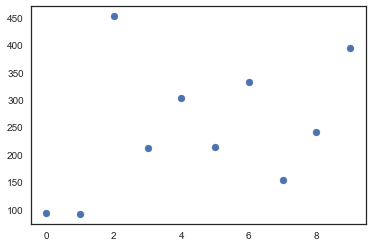

In [10]:
plt.scatter(range(len(attend_duration_arr)), np.array(attend_duration_arr))
plt.show()